In [1]:
import requests
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
#%inline matplotlib
from scipy import stats # statistics
import sklearn.metrics as metrics # metrics for model evaluation
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
import seaborn as sns

/Users/edwardamoah/Documents/GitHub/FloralArea/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load images for analysis
files = os.listdir('/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/evaluation_images_experiment_1')
files = ['/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/evaluation_images_experiment_1/' + file for file in files]

In [6]:
area = []
mask = []
for file in files:
    try:
        print(file)
        url = 'http://localhost:8000/estimate_area/flower/0.5'
        file = {'uploaded_file': open(file, 'rb')}
        response = requests.post(url, files=file)
        response = response.json()
        area.append(response['area'])
        mask.append(response['mask'])
    except:
        area.append(np.nan)
        mask.append(np.nan)
        print(f'File {file} failed')
    #print(response.json())

/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/evaluation_images_experiment_1/PXL_20240214_172530114_80cm_F6_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/evaluation_images_experiment_1/PXL_20240214_173554009_80cm_F11_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/evaluation_images_experiment_1/PXL_20240214_175708911_100cm_F23_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/evaluation_images_experiment_1/PXL_20240214_175352365_100cm_F21_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/evaluation_images_experiment_1/PXL_20240214_174000188_80cm_F13_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/evaluation_images_experiment_1/PXL_20240214_175405036_80cm_F21_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/evaluation_images_experiment_1/PXL_20240214_175033319_60cm_F18_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/evaluation_images_experiment_1/PXL_

In [7]:
# Create a dataframe with the images and their floral area predictions from the FloralArea Algorithm
filename= [file.split('/')[-1] for file in files]
df = pd.DataFrame({'predicted_area': area, 'images': filename})

In [8]:
# Load the csv data with the ImageJ floral area measurments
#df1 = pd.read_csv('/Users/edwardamoah/Downloads/floralarea_experiment_1 - floralarea.csv')

df1 = pd.read_csv('/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/floralarea_experiment_1 - floralarea.csv')

In [9]:
# Merge the dataframes together
df.dropna(inplace=True)
df2 = df1[['images', 'flower_number','distance', 'flower_color','imagej_area', 'morphology']].merge(df, on='images')

In [10]:
# function to convert inches square to cm square
def convert_inch_to_cm(inch):
    cm = inch * 6.4516
    return cm


In [11]:
# convert inches area to meters
df2['predicted_area'] = df2['predicted_area'].apply(convert_inch_to_cm)
df2['imagej_area'] = df2['imagej_area'].apply(convert_inch_to_cm)

In [12]:
# filtere columns for analysis
data = df2[['predicted_area','flower_number','distance','imagej_area','flower_color','morphology']]


In [13]:
######### Acuracy Evaluation with regression analysis #######

Text(20, 250, 'RMSE = 10.76 ')

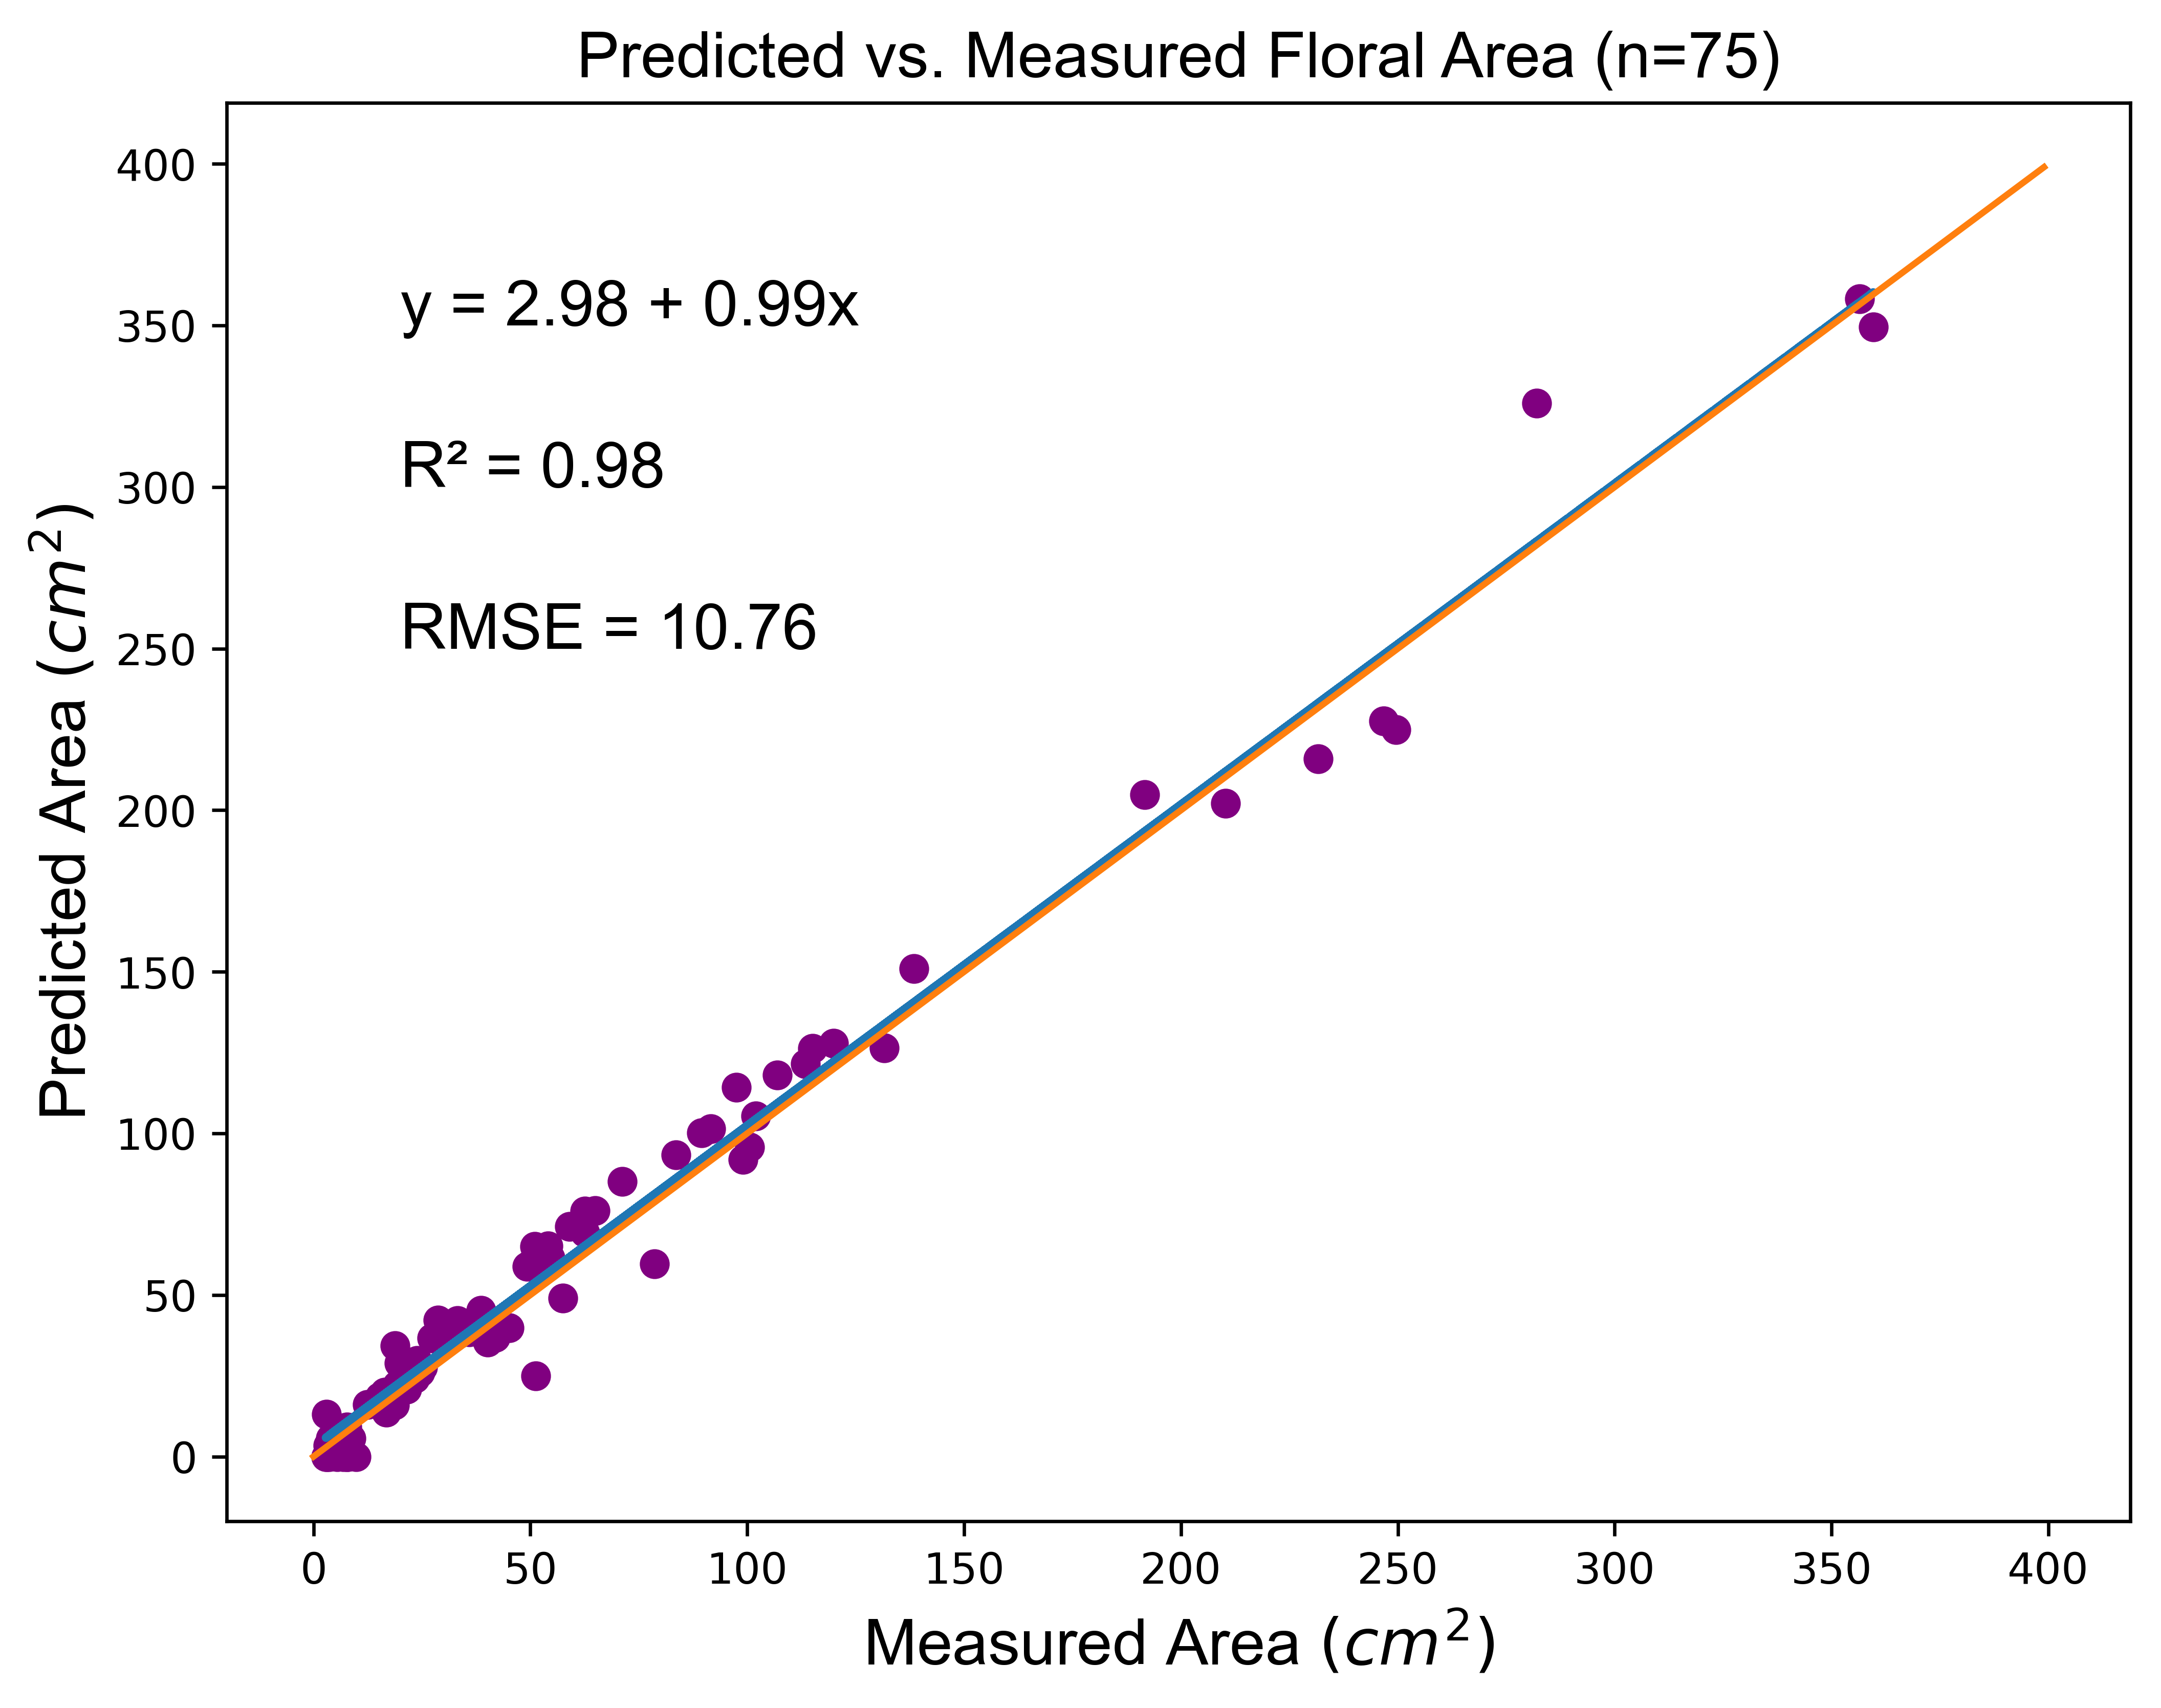

In [14]:
# make residual plot for the corelation between predicted and measure dbh values
x = np.array(data['imagej_area']); y = np.array( [ float(x) for x in data['predicted_area']])
a, b = np.polyfit(x, y , 1)

rmse = np.sqrt(mean_squared_error(x, y))

figure(figsize=(8, 6), dpi=600)

# font 
font = {'fontname':'Arial'}

plt.scatter(x, y, color='purple')
plt.plot(x, a*x+b, linestyle='--', linewidth=2)
plt.plot(np.arange(400), np.arange(400))
plt.xlabel("Measured Area $\\left( cm^2 \\right)$", **font, size=15)
plt.ylabel("Predicted Area $\\left( cm^2 \\right)$", **font, size=15)
plt.title(f"Predicted vs. Measured Floral Area (n={len(data)})", **font, size=15)

# add fitted regression equation to plot
plt.text(20, 350, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=15, **font)

# add the r2
plt.text(20,300, f"R\u00b2 = {round(r2_score(x,y),2)} ", size=15, **font)

# add rmse
plt.text(20,250, f"RMSE = {round(rmse,2)} ", size=15, **font)

In [15]:
############# BIAS Analysis on different flower color, petal display and distances ###########

In [16]:
def Bias(pred, obs):
    return pred - obs

In [17]:
data["bias"] = data.apply(lambda x: Bias(x.predicted_area, x.imagej_area), axis=1)

In [18]:
np.mean(data['bias'])

2.534680709067568

In [19]:
# filter data by flower color
data_t1 = data.query('flower_color == "T1"')
data_t2 = data.query('flower_color == "T2"')
data_t3 = data.query('flower_color == "T3"')
data_t4 = data.query('flower_color == "T4"')
data_t5 = data.query('flower_color == "T5"')

([<matplotlib.axis.XTick at 0x12fa6aa30>,
 [Text(0, 0, 'T1(n=18)'),
  Text(1, 0, 'T2(n=15)'),
  Text(2, 0, 'T3(n=21)'),
  Text(3, 0, 'T4(n=17)'),
  Text(4, 0, 'T5(n=4)')])

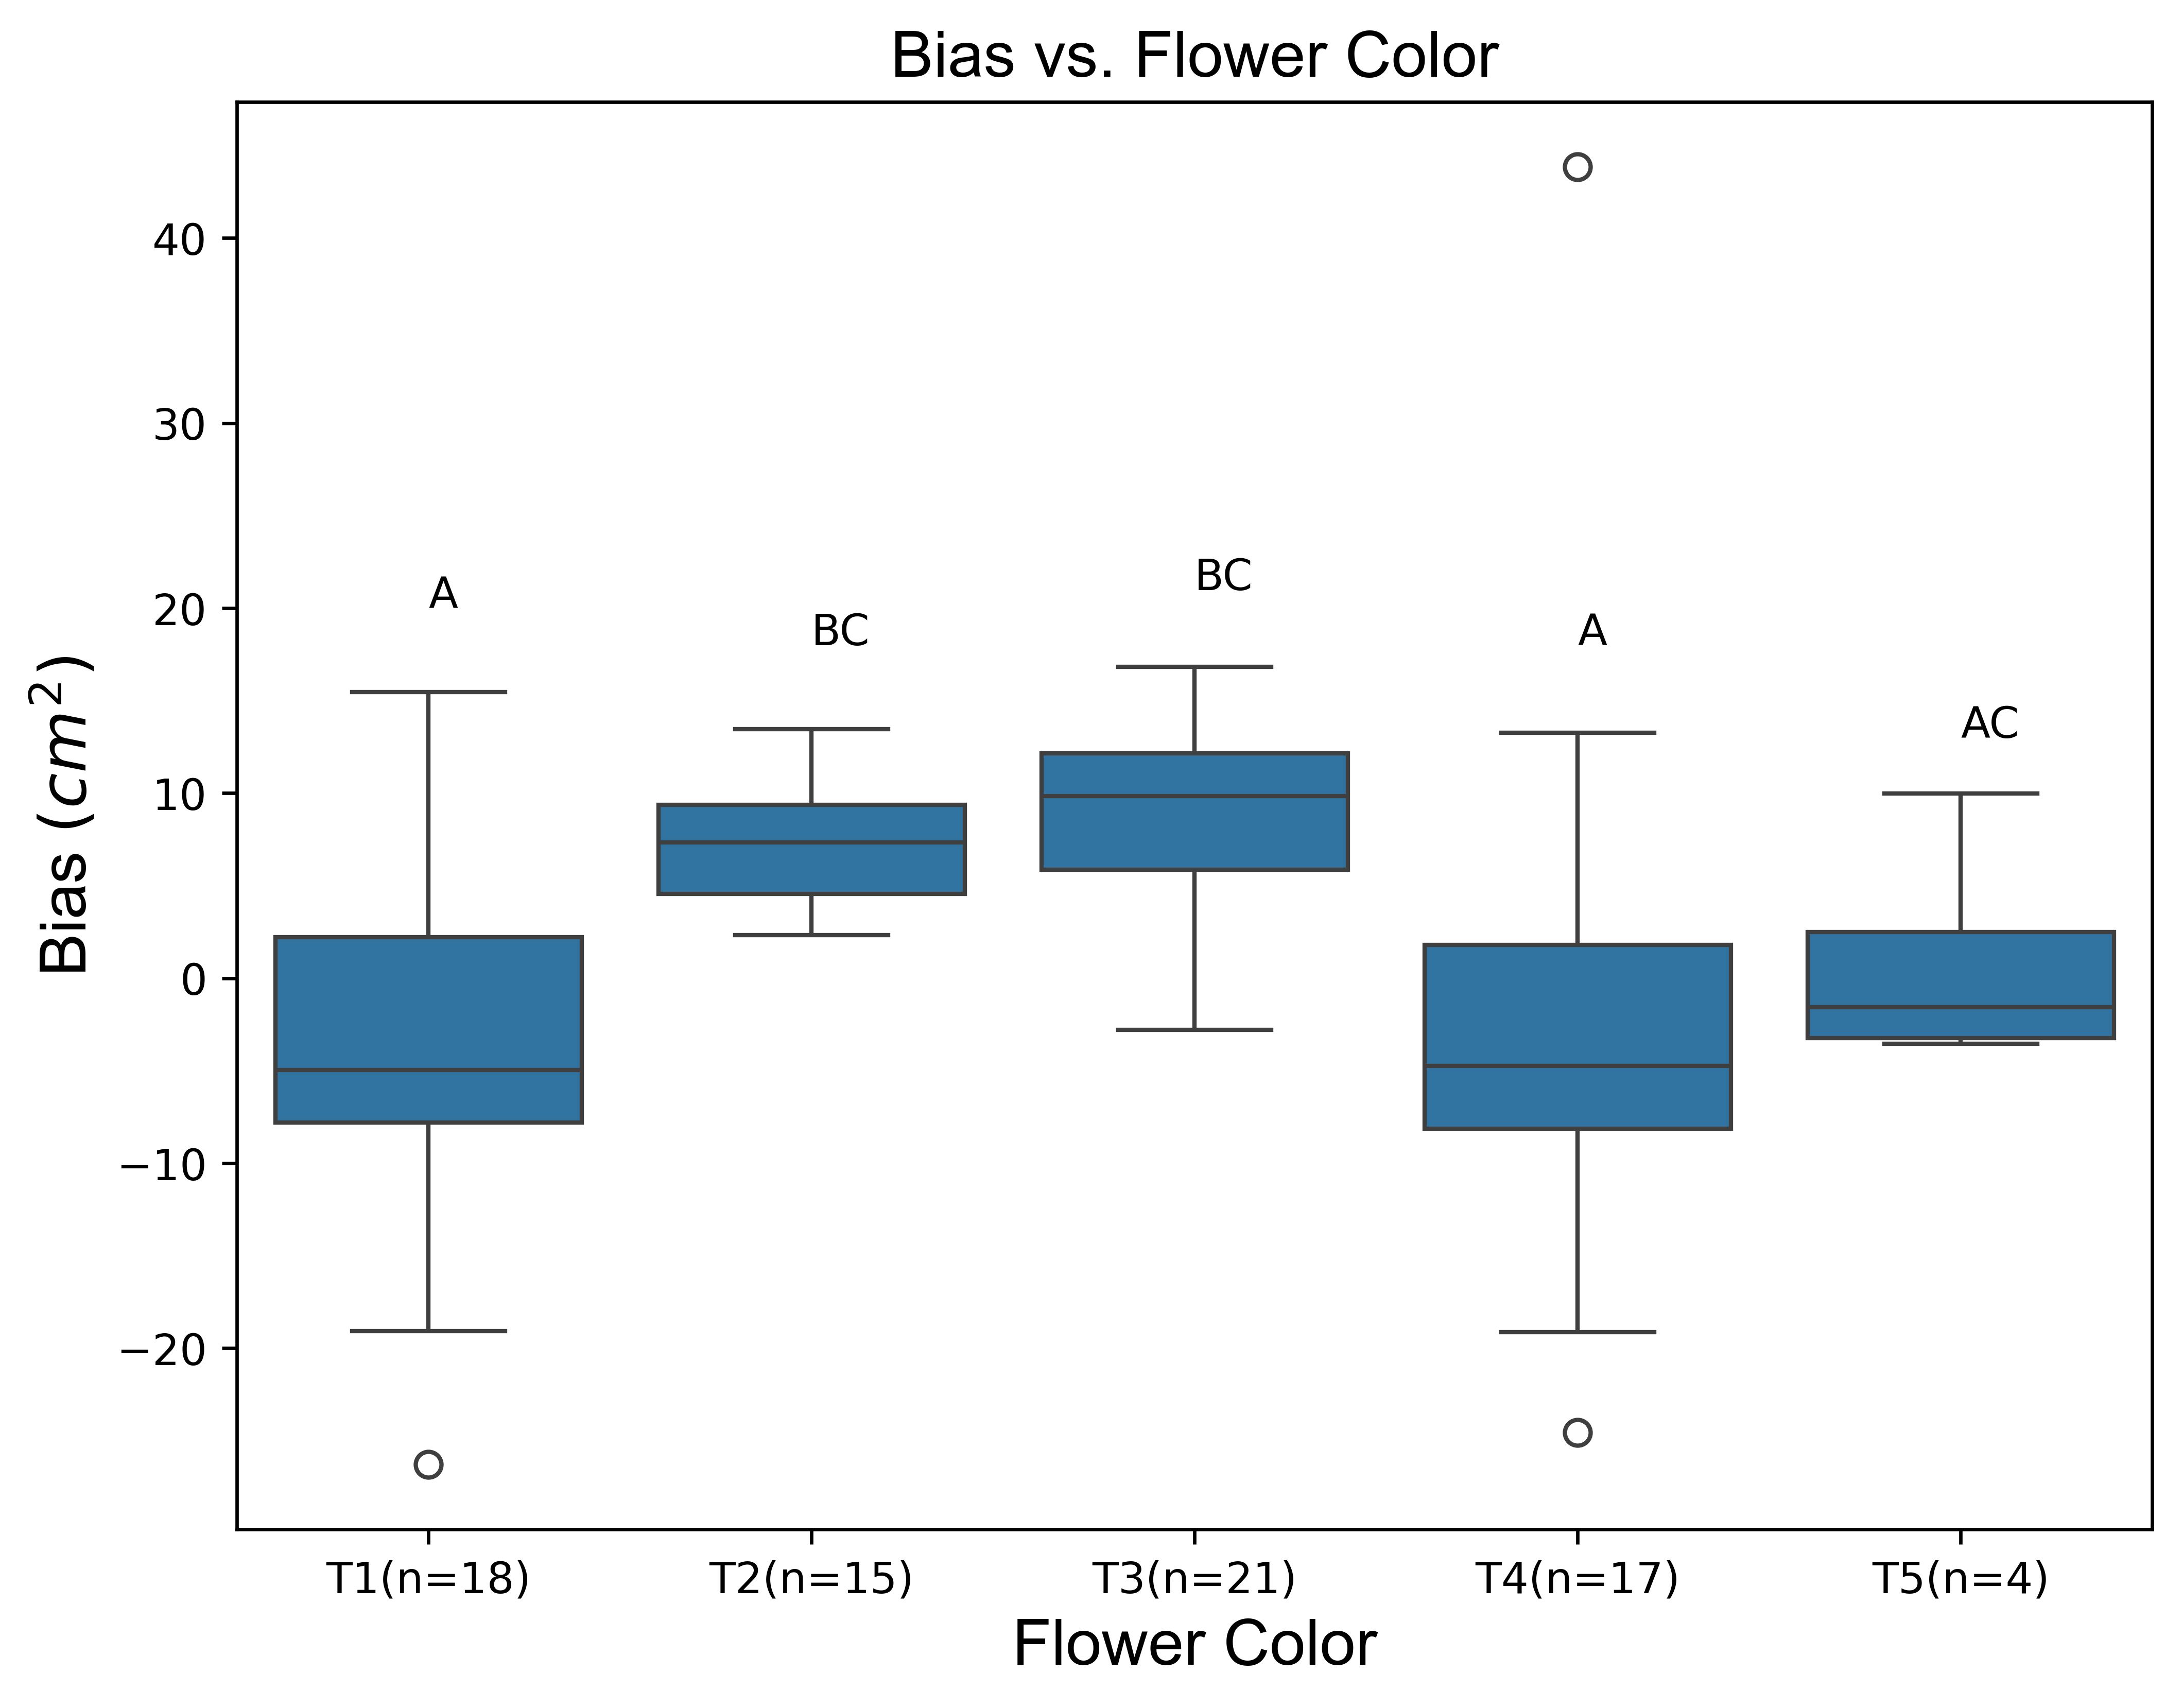

In [20]:
figure(figsize=(8, 6), dpi=600)
sns.boxplot(x="flower_color", y="bias", data=data, order=['T1','T2', 'T3', 'T4', 'T5'])
plt.xlabel("Flower Color", **font, size=15)
plt.ylabel("Bias $\\left( cm^2 \\right)$", **font, size=15)
plt.title("Bias vs. Flower Color", **font, size=15)
plt.text(0,20,"A")
plt.text(1,18,"BC")
plt.text(2,21,"BC")
plt.text(3,18,"A")
plt.text(4,13,"AC")
plt.xticks([0,1,2,3,4], [f'T1(n={len(data_t1)})', f'T2(n={len(data_t2)})', f'T3(n={len(data_t3)})', f'T4(n={len(data_t4)})', f'T5(n={len(data_t5)})'  ])

In [21]:
# filter data for morphology analysis
data_c1 = data.query('morphology == "C1"')
data_c2 = data.query('morphology == "C2"')
data_c3 = data.query('morphology == "C3"')

([<matplotlib.axis.XTick at 0x12fafb280>,
 [Text(0, 0, 'C1 (n=18)'), Text(1, 0, 'C2 (n=36)'), Text(2, 0, 'C3 (n=21)')])

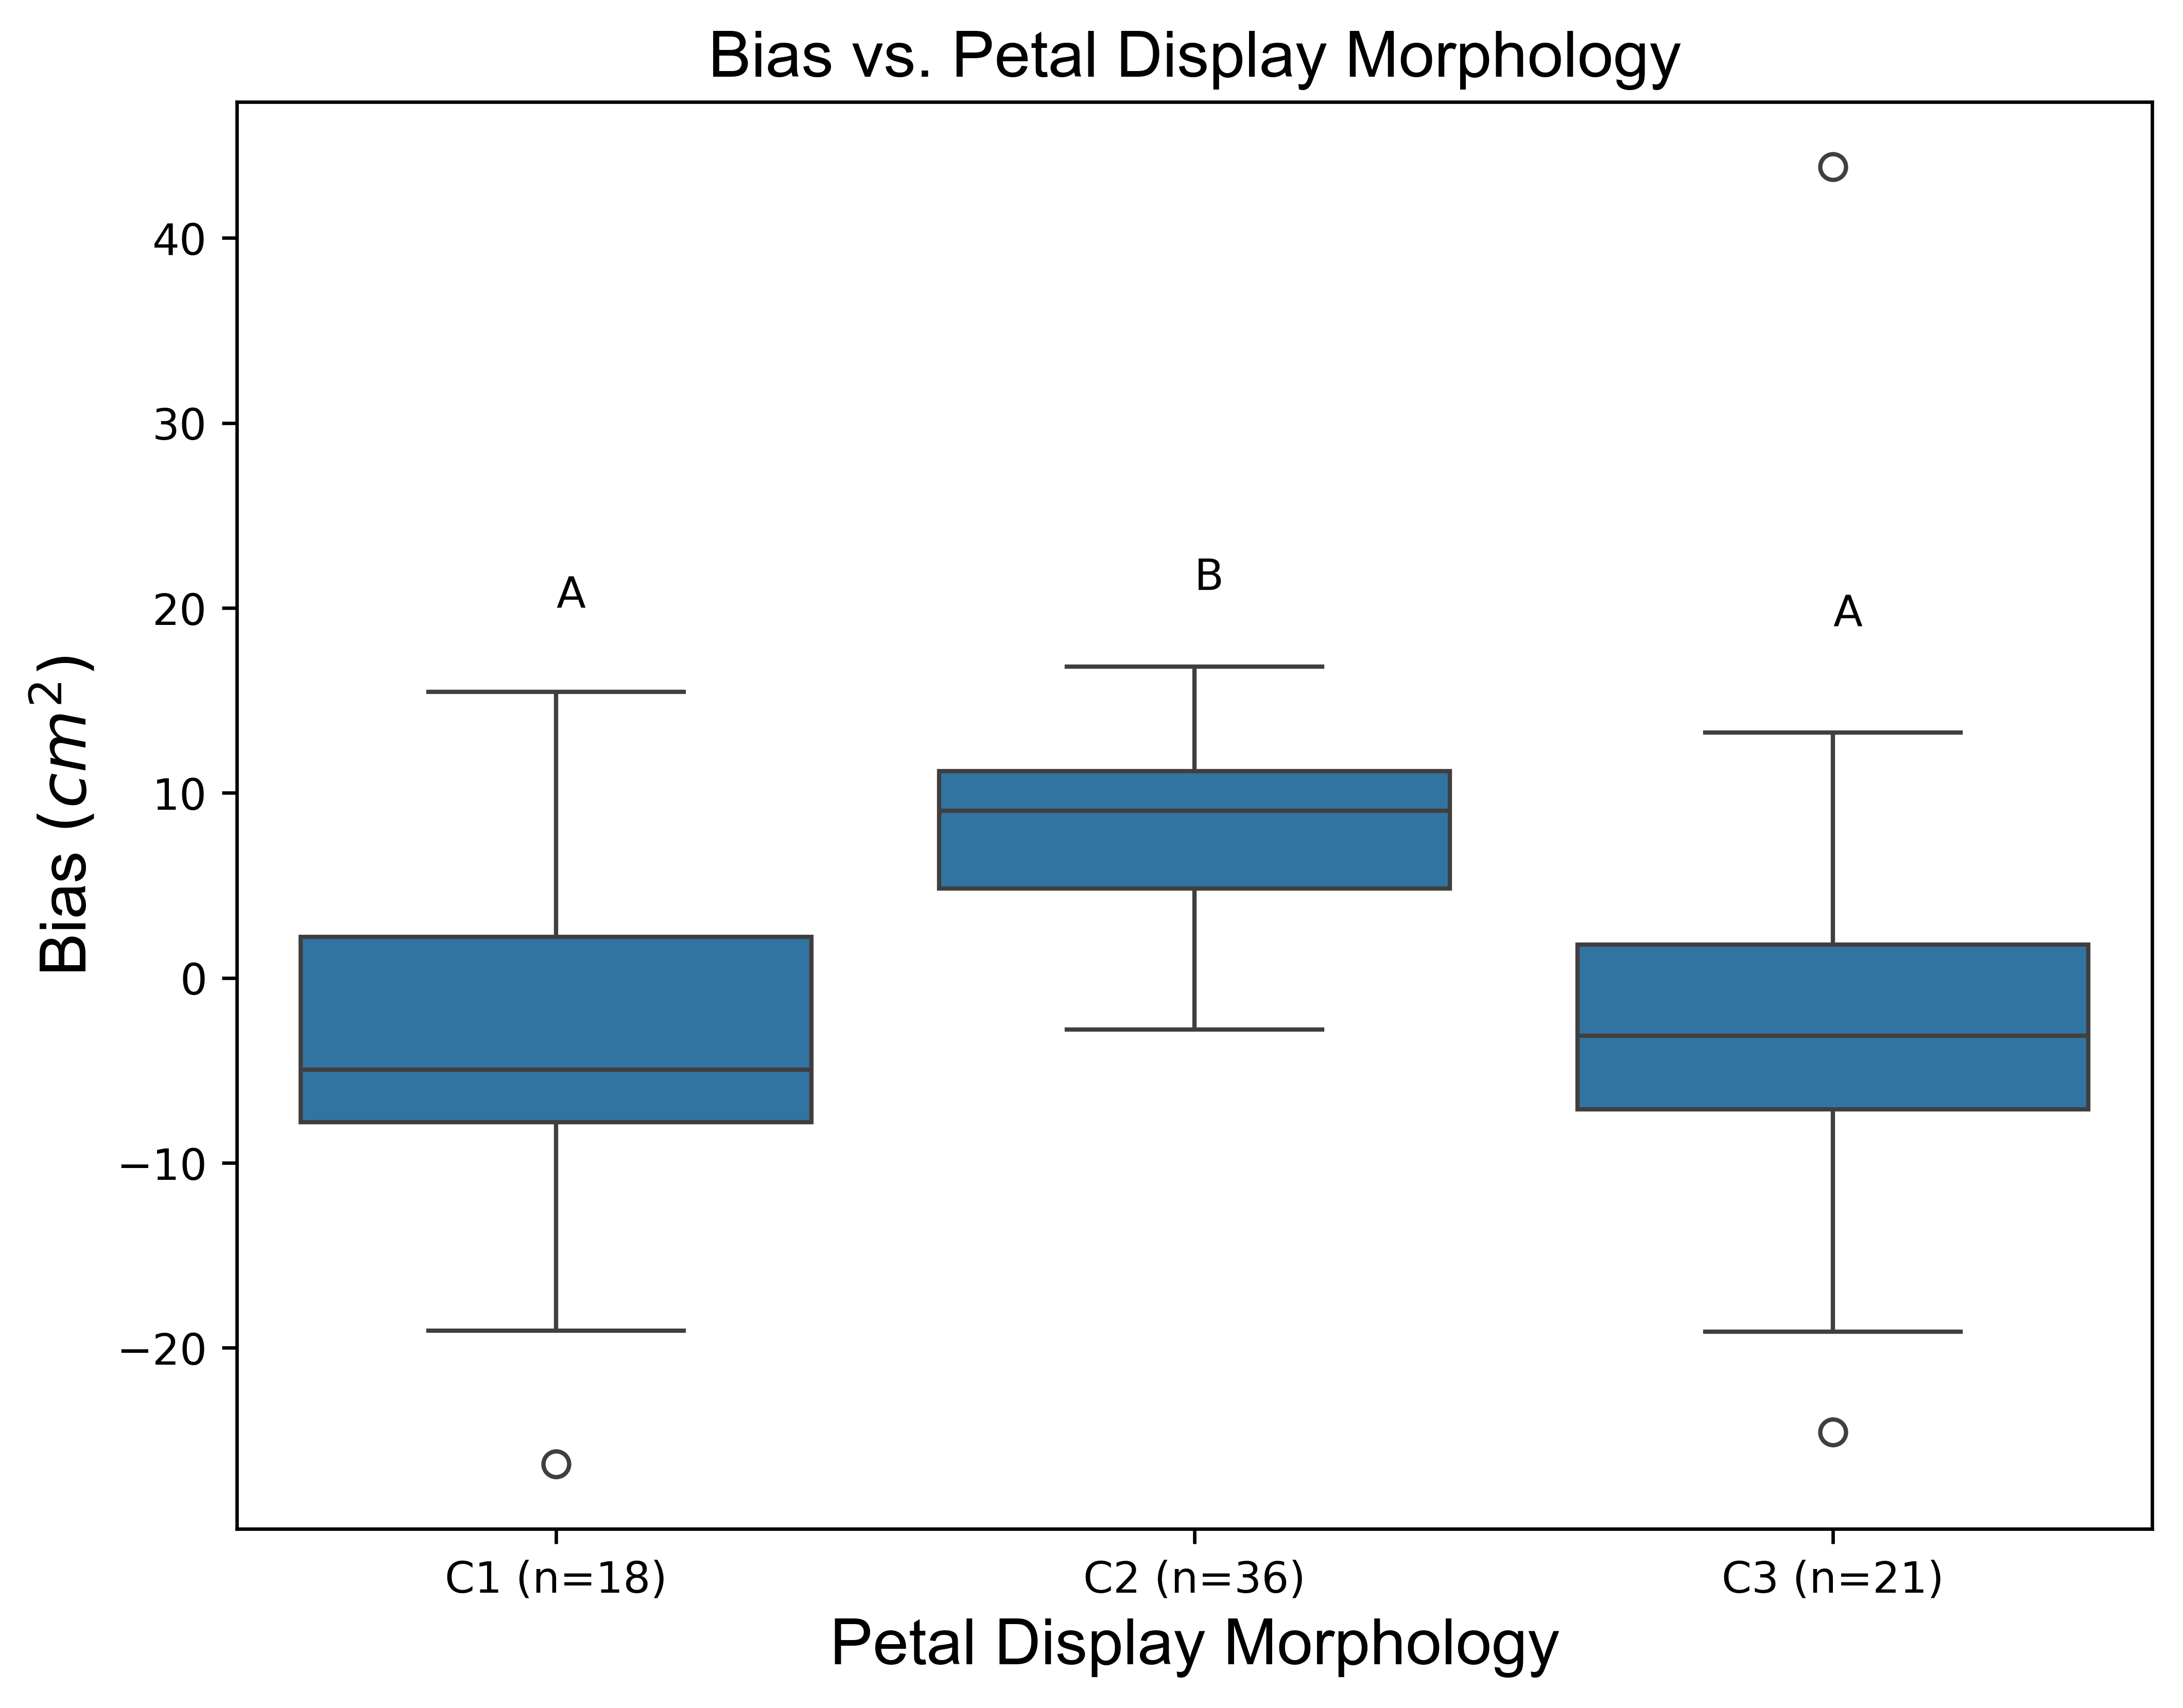

In [22]:
figure(figsize=(8, 6), dpi=600)
sns.boxplot(x="morphology", y="bias", data=data, order=['C1','C2', 'C3'])
plt.xlabel("Petal Display Morphology", **font, size=15)
plt.ylabel("Bias $\\left( cm^2 \\right)$", **font, size=15)
plt.title("Bias vs. Petal Display Morphology", **font, size=15)
plt.text(0,20,"A")
plt.text(1,21,"B")
plt.text(2,19,"A")
plt.xticks([0,1,2], [f'C1 (n={len(data_c1)})', f'C2 (n={len(data_c2)})', f'C3 (n={len(data_c3)})'])

In [23]:
# filter data for distance anlysis
data_60 = data.query('distance == "60cm"')
data_80 = data.query('distance == "80cm"')
data_100 = data.query('distance == "100cm"')

([<matplotlib.axis.XTick at 0x12fbf0ca0>,
 [Text(0, 0, '60cm (n=22)'),
  Text(1, 0, '80cm (n=23)'),
  Text(2, 0, '100cm (n=27)')])

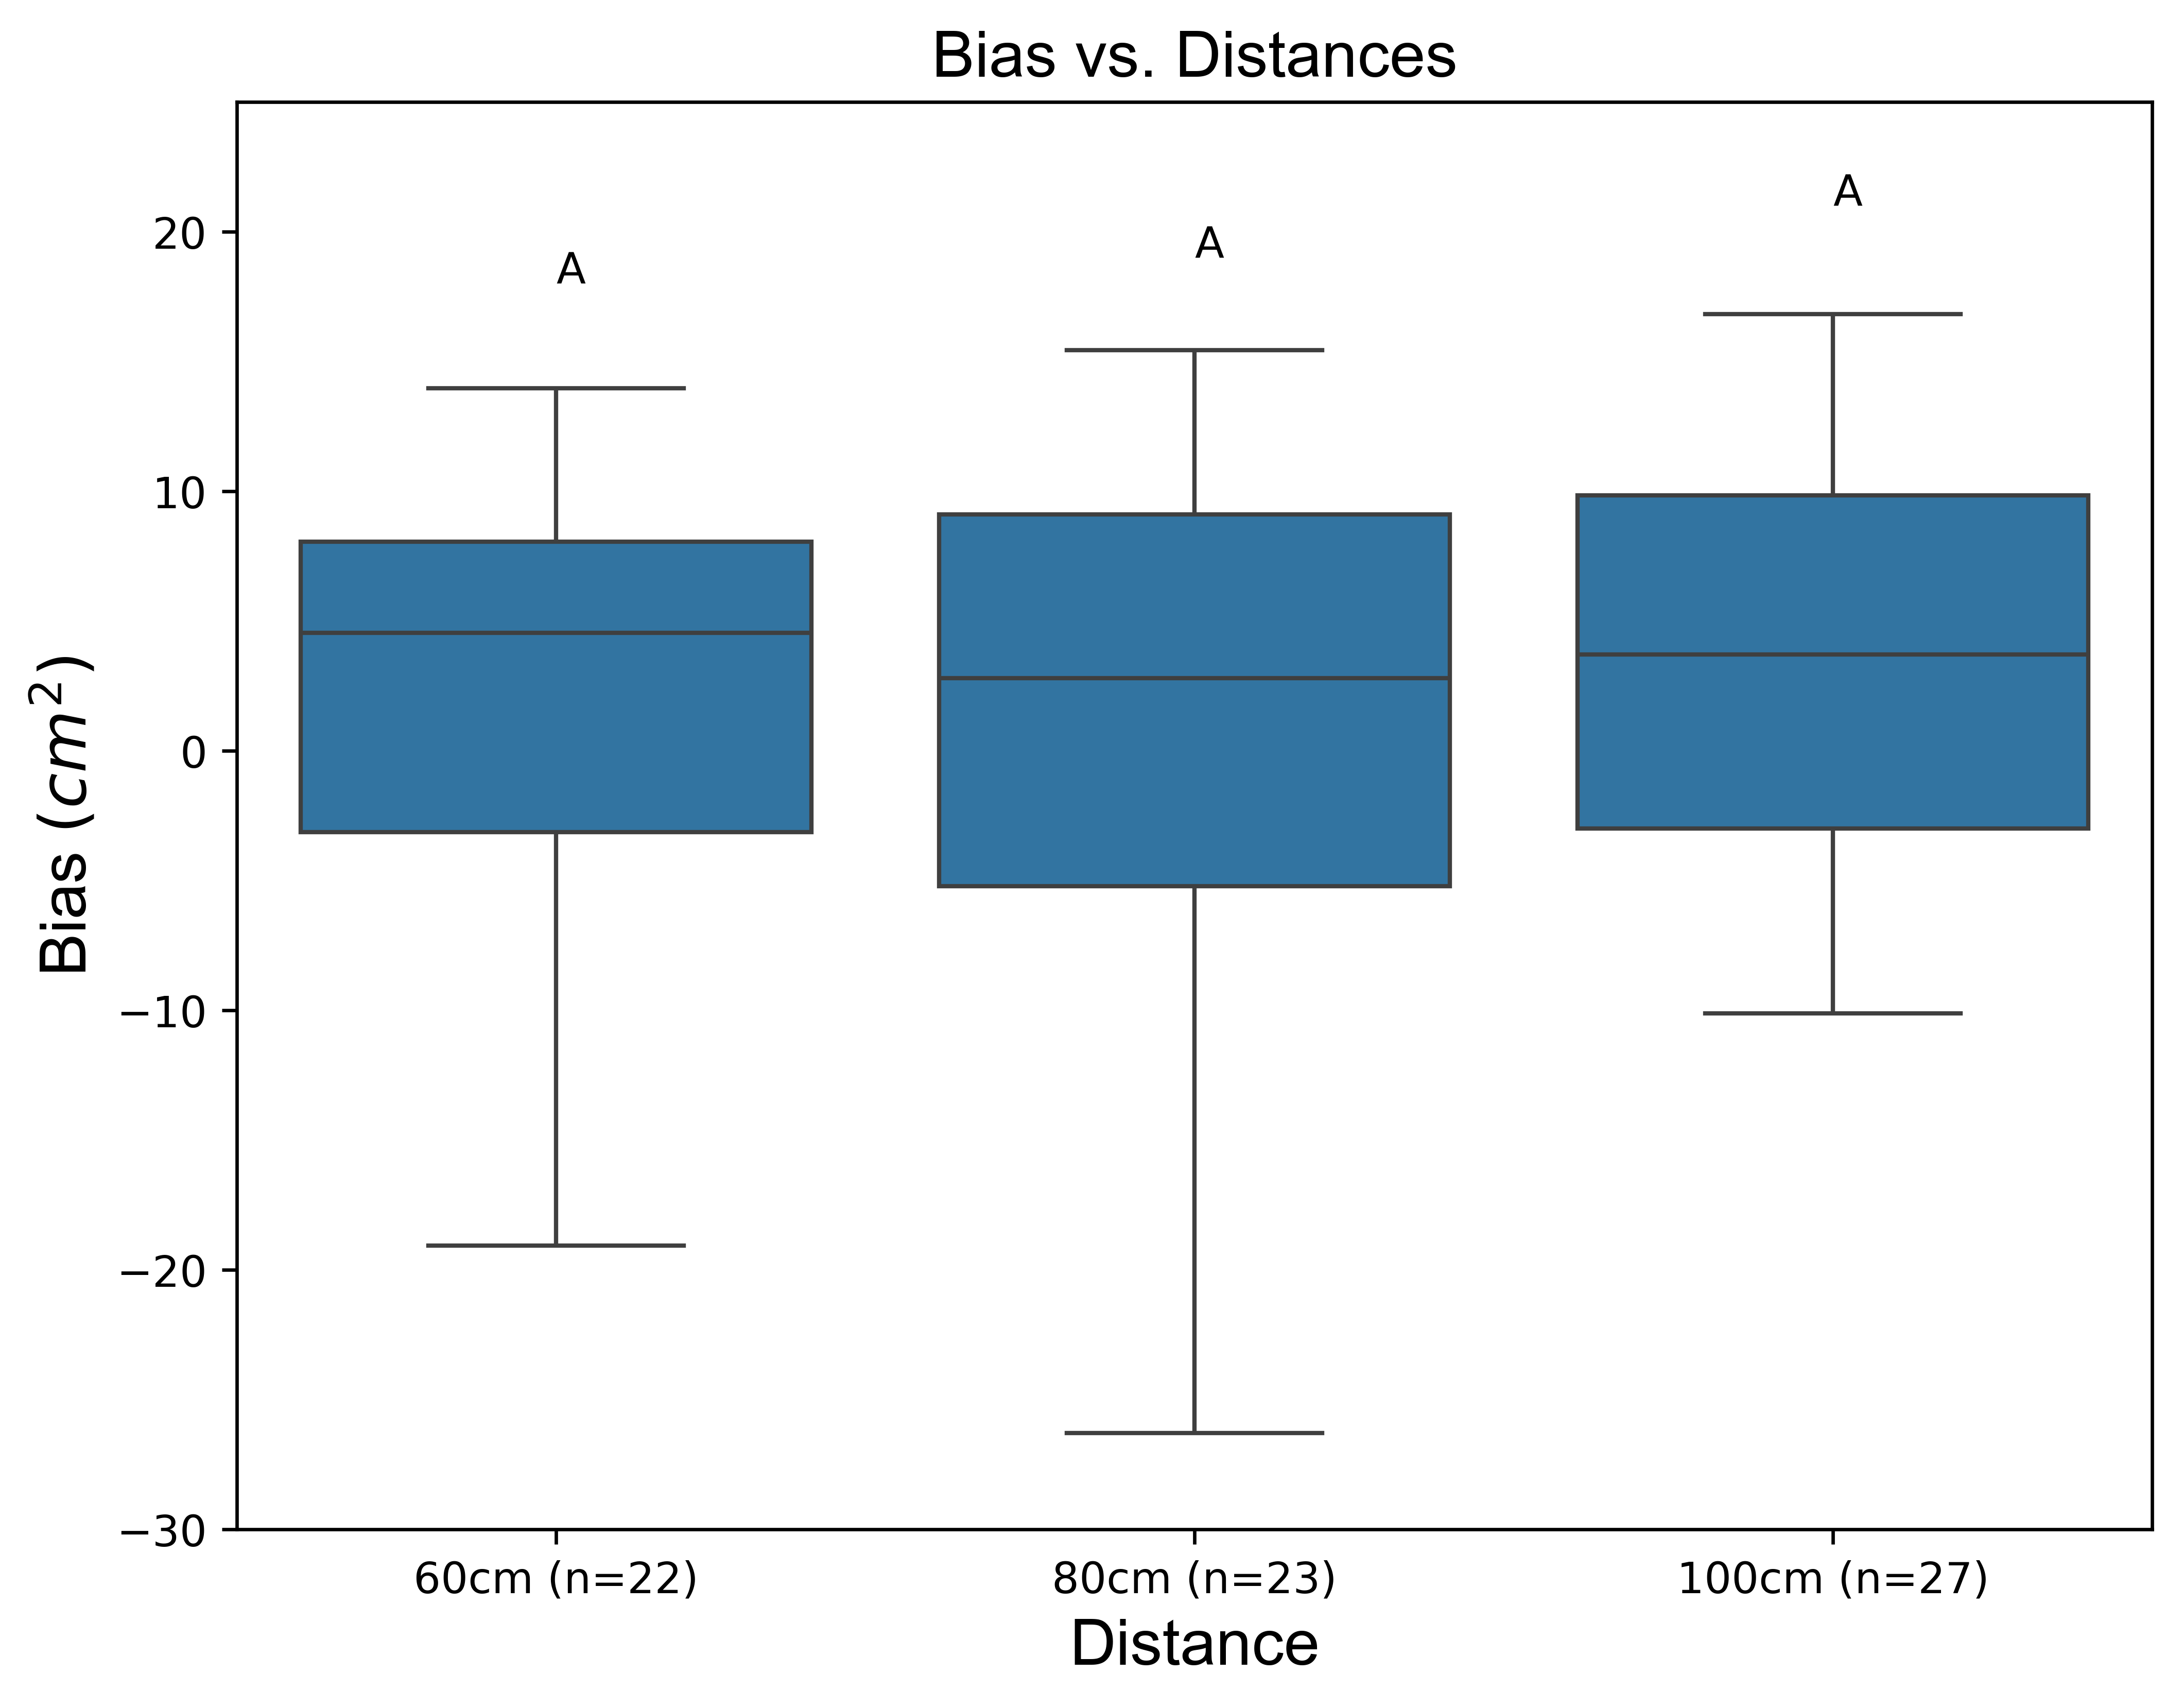

In [24]:
figure(figsize=(8, 6), dpi=600)
sns.boxplot(x="distance", y="bias", data=data, order=['60cm','80cm', '100cm'])
plt.xlabel("Distance", **font, size=15)
plt.ylabel("Bias $\\left( cm^2 \\right)$", **font, size=15)
plt.title("Bias vs. Distances", **font, size=15)
plt.text(0,18,"A")
plt.text(1,19,"A")
plt.text(2,21,"A")
#plt.text(3,18,"A")
plt.ylim(-30,25)
plt.xticks([0,1,2], [f'60cm (n={len(data_60)})', f'80cm (n={len(data_80)})', f'100cm (n={len(data_100)})'])

In [25]:
########## One-Way ANOVA Analysis ##########

In [26]:
## Flower Color ##

In [27]:
# filter data by flower color
data_t1 = data.query('flower_color == "T1"')
data_t2 = data.query('flower_color == "T2"')
data_t3 = data.query('flower_color == "T3"')
data_t4 = data.query('flower_color == "T4"')
data_t5 = data.query('flower_color == "T5"')

In [28]:
[np.mean(data_t1['bias']), np.mean(data_t2['bias']), np.mean(data_t3['bias']), np.mean(data_t4['bias']), np.mean(data_t5['bias']) ]

[-3.749588467002247,
 7.320965959976801,
 8.522038020235092,
 -2.02886115868807,
 0.8267493648040637]

In [29]:
# Read about anova testing above

# Perform ANOVA test
result = stats.f_oneway(data[data['flower_color'] == 'T1']['bias'],
                        data[data['flower_color'] == 'T2']['bias'],
                        data[data['flower_color'] == 'T3']['bias'],
                        data[data['flower_color'] == 'T4']['bias'],
                        data[data['flower_color'] == 'T5']['bias'],
                        )

# Print the ANOVA test result
print("ANOVA Test Result:")
print("F-value:", result.statistic)
print("p-value:", result.pvalue)

ANOVA Test Result:
F-value: 6.301059878142898
p-value: 0.00021719824203910438


In [30]:
# filter data for morphology analysis
data_c1 = data.query('morphology == "C1"')
data_c2 = data.query('morphology == "C2"')
data_c3 = data.query('morphology == "C3"')

In [31]:
[np.mean(data_c1['bias']), np.mean(data_c2['bias']), np.mean(data_c3['bias'])]

[-3.749588467002247, 8.021591328460804, -1.484935344689568]

In [32]:
#https://www.statology.org/null-hypothesis-for-anova/

# Read about anova testing above

# Perform ANOVA test
result = stats.f_oneway(data_c1["bias"], data_c2["bias"], data_c3["bias"])

# Print the ANOVA test result
print("ANOVA Test Result:")
print("F-value:", result.statistic)
print("p-value:", result.pvalue)

ANOVA Test Result:
F-value: 12.647588841584856
p-value: 1.9619255030494833e-05


In [33]:
# filter data for distance anlysis
data_60 = data.query('distance == "60cm"')
data_80 = data.query('distance == "80cm"')
data_100 = data.query('distance == "100cm"')

In [34]:
len(data_60) + len(data_80) + len(data_100)

72

In [35]:
[np.mean(data_60['bias']), np.mean(data_80['bias']), np.mean(data_100['bias'])]

[2.2834514617390185, 0.46296630174656067, 3.6388080165216197]

In [36]:
#https://www.statology.org/null-hypothesis-for-anova/

# Read about anova testing above

# Perform ANOVA test
result = stats.f_oneway(data_60["bias"], data_80["bias"], data_100["bias"])

# Print the ANOVA test result
print("ANOVA Test Result:")
print("F-value:", result.statistic)
print("p-value:", result.pvalue)

ANOVA Test Result:
F-value: 0.6977232457992307
p-value: 0.5011942038641582


In [37]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey HSD test
tukey_results = pairwise_tukeyhsd(
    endog=data['bias'],    # Dependent variable
    groups=data['flower_color'],    # Grouping variable
    alpha=0.05               # Significance level
)

# Print results
print(tukey_results)

# Optional: Plot results
#tukey_results.plot_simultaneous()


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
    T1     T2  11.0706 0.0093   1.9808 20.1603   True
    T1     T3  12.2716  0.001   3.9202 20.6231   True
    T1     T4   1.7207 0.9818  -7.0725  10.514  False
    T1     T5   4.5763 0.8991  -9.7958 18.9485  False
    T2     T3   1.2011 0.9954  -7.5886  9.9907  False
    T2     T4  -9.3498 0.0449 -18.5603 -0.1394   True
    T2     T5  -6.4942 0.7264 -21.1253  8.1369  False
    T3     T4 -10.5509 0.0074 -19.0336 -2.0682   True
    T3     T5  -7.6953 0.5537 -21.8795   6.489  False
    T4     T5   2.8556 0.9812 -11.5932 17.3044  False
-----------------------------------------------------


In [38]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey HSD test
tukey_results = pairwise_tukeyhsd(
    endog=data['bias'],    # Dependent variable
    groups=data['morphology'],    # Grouping variable
    alpha=0.05               # Significance level
)

# Print results
print(tukey_results)

# Optional: Plot results
#tukey_results.plot_simultaneous()


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
    C1     C2  11.7712 0.0001   5.4259 18.1165   True
    C1     C3   2.2647  0.724  -4.7957   9.325  False
    C2     C3  -9.5065  0.001 -15.5421  -3.471   True
-----------------------------------------------------


In [39]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Example data
# data = pd.DataFrame({
#     'values': [5.1, 6.2, 7.3, 5.8, 6.5, 6.9, 7.4, 6.8, 7.2, 6.7, 5.5, 6.1, 5.8, 5.7, 6.0],
#     'group': ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C']
# })

data_temp = data.query(" distance != '90cm'")

# Perform Tukey HSD test
tukey_results = pairwise_tukeyhsd(
    endog=data_temp['bias'],    # Dependent variable
    groups=data_temp['distance'],    # Grouping variable
    alpha=0.05               # Significance level
)

# Print results
print(tukey_results)

# Optional: Plot results
#tukey_results.plot_simultaneous()


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 100cm   60cm  -1.3554 0.8726  -7.878 5.1673  False
 100cm   80cm  -3.1758 0.4687 -9.6199 3.2682  False
  60cm   80cm  -1.8205 0.7964  -8.593  4.952  False
---------------------------------------------------


In [85]:
#### save data ####
df2.to_csv("/Users/edwardamoah/Documents/GitHub/FloralArea/research/output/accuracy_bias_results.csv")

In [42]:
################ Time Evaluation #################

In [43]:
files = os.listdir('/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/experiment_3_images')
files = ['/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/experiment_3_images/' + file for file in files]

In [44]:
import time 
area = []
mask = []
times = []

for file in files:
    start_time = time.time()
    print(file)
    url = 'http://localhost:8000/estimate_area/flower/0.5'
    file = {'uploaded_file': open(file, 'rb')}
    response = requests.post(url, files=file)
    response = response.json()
    area.append(response['area'])
    mask.append(response['mask'])
    times.append(time.time() - start_time)
    
    #print(response.json())

/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/experiment_3_images/PXL_20240214_171637048_100cm_F1_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/experiment_3_images/PXL_20240214_172005738_100cm_F3_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/experiment_3_images/PXL_20240214_171819047_100cm_F2_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/experiment_3_images/PXL_20240214_171937537_100cm_F3_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/experiment_3_images/PXL_20240214_171827242_100cm_F2_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/experiment_3_images/PXL_20240214_171837365_60cm_F2_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/experiment_3_images/PXL_20240214_171953310_80cm_F3_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/experiment_3_images/PXL_20240214_172351335_100cm_F5_.jpg
/Users/edwardamoah/Documents/GitHub/FloralArea/research/da

In [59]:
filename= [file.split('/')[-1] for file in files]
df5 = pd.DataFrame({'area': area, 'mask': mask, 'images': filename, 'algorithm_time': times})

In [60]:
# load other data
df6 = pd.read_csv("/Users/edwardamoah/Documents/GitHub/FloralArea/research/data/measuring_time_experiment3.csv")

In [61]:

df6["name"] = df6["images"].str.split("_.tif").str[0]

In [62]:
df5["name"] = df5["images"].str.split("_.jpg").str[0]

In [87]:
df7 = df5.merge(df6[['name','imagej_time']], on="name")

In [88]:
df7[["algorithm_time", "imagej_time"]].describe()

,algorithm_time,imagej_time
count,10.000000,10.000000
mean,1.065323,232.371000
std,0.411666,113.107935
min,0.820400,80.530000
25%,0.873447,121.557500
50%,0.901407,282.020000
75%,1.040654,301.807500
max,2.200744,379.540000


In [89]:
df7["algorithm_time"].mean()

1.065322995185852

In [90]:
df7["imagej_time"].mean()

232.371

In [91]:
df7["algorithm_time"].sum()

10.65322995185852

In [92]:
df7["imagej_time"].sum()/60

38.728500000000004

In [93]:
df7[['images','algorithm_time', 'imagej_time']]

,images,algorithm_time,imagej_time
0,PXL_20240214_171637048_100cm_F1_.jpg,2.200744,297.12
1,PXL_20240214_172005738_100cm_F3_.jpg,0.820400,114.42
2,PXL_20240214_171819047_100cm_F2_.jpg,0.885711,271.53
3,PXL_20240214_171937537_100cm_F3_.jpg,0.882622,80.53
4,PXL_20240214_171827242_100cm_F2_.jpg,0.870388,292.51
5,PXL_20240214_171837365_60cm_F2_.jpg,0.862583,303.37
6,PXL_20240214_171953310_80cm_F3_.jpg,1.048307,90.72
7,PXL_20240214_172351335_100cm_F5_.jpg,1.147678,142.97
8,PXL_20240214_171724834_60cm_F1_.jpg,1.017694,379.54
9,PXL_20240214_171717068_80cm_F1_.jpg,0.917103,351.00


In [94]:
df7.to_csv('/Users/edwardamoah/Documents/GitHub/FloralArea/research/output/efficiency_assessment_results.csv')

In [21]:
############### Evaluation of Semantic Segmentation Model ####################

In [ ]:
## flower segmentation model

In [22]:
from ultralytics import YOLO

# Load a model
#model = YOLO("yolo11n.pt")  # load an official model
model = YOLO("/Users/edwardamoah/Documents/GitHub/FloralArea/models/flower_100_best.pt")  # load a custom model


In [23]:
metrics = model.val( data = '/Users/edwardamoah/Documents/GitHub/FloralArea/datasets/FloralArea-7/data.yaml') 

Ultralytics 8.3.53 🚀 Python-3.9.6 torch-2.2.0 CPU (Apple M3 Pro)
YOLOv8m-seg summary (fused): 245 layers, 27,225,858 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /Users/edwardamoah/Documents/GitHub/FloralArea/datasets/FloralArea-7/valid/labels.cache... 164 images, 5 backgrounds, 0 corrupt: 100%|██████████| 164/164 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [02:04<00:00, 11.35s/it]


                   all        164       1261      0.561      0.338      0.347      0.284      0.589      0.323      0.342      0.263
                   bud         50        104      0.293      0.154      0.131     0.0652      0.311      0.144      0.128     0.0498
           dead_flower         41         72      0.313      0.153      0.167     0.0887      0.359      0.125      0.165     0.0834
                flower        138        987       0.77      0.707      0.762      0.562      0.794      0.658      0.741      0.455
                  leaf         42         80     0.0498     0.0125     0.0257     0.0176     0.0871     0.0125     0.0223     0.0143
      reference_object         10         10      0.942          1      0.995      0.967      0.984          1      0.995      0.976
                  stem          6          8          1          0    0.00274   0.000274          1          0          0          0
Speed: 1.2ms preprocess, 748.7ms inference, 0.0ms loss, 0.4ms postpro

In [ ]:
## Reference object

In [24]:
from ultralytics import YOLO

# Load a model
#model = YOLO("yolo11n.pt")  # load an official model
model = YOLO("/Users/edwardamoah/Documents/GitHub/FloralArea/models/tilled_reference_object_best.pt")  # load a custom model


In [25]:
metrics = model.val( data = '/Users/edwardamoah/Documents/GitHub/FloralArea/datasets/FloralArea-15/data.yaml') 

Ultralytics 8.3.53 🚀 Python-3.9.6 torch-2.2.0 CPU (Apple M3 Pro)
YOLOv8m-seg summary (fused): 245 layers, 27,223,542 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /Users/edwardamoah/Documents/GitHub/FloralArea/datasets/FloralArea-15/valid/labels.cache... 164 images, 66 backgrounds, 0 corrupt: 100%|██████████| 164/164 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [02:08<00:00, 11.72s/it]


                   all        164        164      0.687      0.694      0.667      0.605      0.693      0.698      0.668      0.561
            background         57        114      0.468      0.447      0.402      0.301      0.479      0.456      0.403       0.29
      reference_object         50         50      0.906       0.94      0.933      0.909      0.907       0.94      0.933      0.832
Speed: 1.2ms preprocess, 777.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /Users/edwardamoah/Documents/GitHub/FloralArea/runs/segment/val15
